# Fit `movefactor` parameter

This notebook uses the elbow method within a revealed preference context to fit the `movefactor` parameter, which defines the cost of relocating as a multiple of GDP. We evaluate the value of capital stock and the total population that immediately relocates under the optimal CIAM scenario using no-climate-change SLR projections and a middle of the road (SSP2) socioeconomic projection. The amount of immediate relocation of capital and population implies, by definition, that the present-day distribution of this capital and population is "suboptimal" within the CIAM framework. This suboptimality could be a function of (a) hidden costs/barriers to relocating that are not sufficiently valued within the existing relocation cost parameterization, and (b) data/parameter inaccuracy. As we start to increase the relocation cost parameter from 0, we see a sharp decline in the amount of immediately relocated population and capital, reflecting that there are real costs to moving. However, even with an implausibly high cost of relocation, we will still see some CIAM segments choose to immediately relocate in this no-climate-change scenario. We assume that this is due largely to (b). We develop a heuristic to estimate a reasonable `movefactor` by finding the value at which 50% of the capital and population that would immediately relocate under an assumption of 0 intangible relocation costs and optimal adaptation now stays put. We average the values obtained separately for population and capital stock. See associated paper for further details.

We also evaluate how much capital is "suboptimally" located within the original GAMS-CIAM specification.

In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from pyCIAM.constants import SOLVCASES
from pyCIAM.io import load_ciam_inputs, load_diaz_inputs
from pyCIAM.run import calc_costs
from rhg_compute_tools.xarray import dataarray_from_delayed
from shared import (
    PATH_DIAZ_INPUTS_INT,
    PATH_MOVEFACTOR_DATA,
    PATH_PARAMS,
    PATH_PARAMS_DIAZ,
    PATH_REFA,
    PATH_SLIIDERS_SEG,
    PATH_SLR_AR6,
    PATHS_SURGE_LOOKUP,
    QUANTILES,
    STORAGE_OPTIONS,
    open_zarr,
    save,
    start_dask_cluster,
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
# When running on larger/scalable dask cluster, may wish to specify number of workers
# Default is LocalCluster which will use the number of CPUs available on local machine
# N_WORKERS_MIN = 7
# N_WORKERS_MAX = 700
SEG_CHUNKSIZE = 500
SEG_CHUNKSIZE_DIAZ = 4050

MOVEFACTOR_RANGE = np.concatenate((np.arange(0, 50, 0.1), [50, 60, 70, 80, 90, 100]))

DESCRIPTION = (
    "Amount of immediately relocated capital and population under optimal adaptation "
    "for a no-climate-change SLR trajectory and SSP2/IIASA socioeconomic trajectory, "
    "as a function of segment and movefactor parameter. Used to estimate movefactor "
    "and to provide baseline adaptation for `noAdaptation` scenario."
)

PARAMS = pd.read_json(PATH_PARAMS)["values"]
PARAMS_DIAZ = pd.read_json(PATH_PARAMS_DIAZ)["values"]

In [4]:
client = start_dask_cluster(
    # n_workers_min=N_WORKERS_MIN,
    # n_workers_max=N_WORKERS_MAX
)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub-dev.bfad7ebc4a904320b41301d11dd74af6/status,


In [4]:
def get_model_kwargs(diaz):
    return dict(
        elev_chunksize=None,
        diaz_protect_height=diaz,
        diaz_construction_freq=diaz,
        diaz_lslr_plan=diaz,
        diaz_negative_retreat=diaz,
        diaz_forward_diff=diaz,
        diaz_fixed_vars_for_onetime_cost=diaz,
        diaz_calc_noadapt_damage_w_lslr=diaz,
        diaz_storm_calcs=diaz,
    )


def load_pyciam(segs):
    return load_ciam_inputs(
        PATH_SLIIDERS_SEG,
        PATH_SLR_AR6,
        PARAMS,
        segs,
        surge_lookup_store=PATHS_SURGE_LOOKUP["seg"],
        mc_dim="quantile",
        ssp="SSP2",
        iam="IIASA",
        include_cc=False,
        include_ncc=True,
        storage_options=STORAGE_OPTIONS,
        quantiles=QUANTILES,
    )


def load_diaz(segs, include_cc=False, include_ncc=True):
    return load_diaz_inputs(
        PATH_DIAZ_INPUTS_INT,
        segs,
        PARAMS_DIAZ,
        include_cc=include_cc,
        include_ncc=include_ncc,
        storage_options=STORAGE_OPTIONS,
    )


def get_refA(segs, mf, diaz=False):
    if diaz:
        surge = None
        inputs, slr = load_diaz(segs)
        npv_start = inputs.npv_start
        eps = 0
    else:
        inputs, slr, surge = load_pyciam(segs)
        slr = slr.unstack("scen_mc").squeeze(drop=True)
        npv_start = None
        eps = 1

    inputs["movefactor"] = mf

    costs, refA = calc_costs(
        inputs, slr, surge_lookup=surge, return_year0_hts=True, **get_model_kwargs(diaz)
    )

    costs = costs.sel(case=SOLVCASES)
    refA = refA.sel(case=SOLVCASES)

    # In the pyCIAM case, we want to assume that agents are weighing the full costs of
    # retreating, not giving them a free "spin-up" step, so we use all model years
    # including the first to calculate NPV rather than starting with "npv_start". (by
    # default, these are the same anyways)
    npv = (
        (costs.sum("costtype") * inputs.dfact)
        .sel(year=slice(npv_start, None))
        .sum("year")
    )
    npv = npv.where(npv.case != "noAdaptation", npv - eps)

    lowest = npv.argmin("case").astype("uint8")
    refA = refA.isel(case=lowest)
    refA["case"] = lowest
    return refA.expand_dims(movefactor=[mf])


def calc_exp_moved(inputs, exp_vars, relocation_hts):
    valid_cases = [ix for ix, i in enumerate(SOLVCASES) if "protect" not in i]
    moved = relocation_hts.case.isin(valid_cases)

    this_refA = relocation_hts.where(moved, 0)

    if "movefactor" in this_refA.dims:
        this_refA = this_refA.chunk({"movefactor": 10})

    bds = inputs.elev_bounds.load()
    exp = inputs[exp_vars].load()

    width = bds.isel(bound=1, drop=True) - bds.isel(bound=0, drop=True)

    wts = (
        np.minimum(
            np.maximum(this_refA - bds.isel(bound=0, drop=True), 0),
            width,
        )
        / width
    )

    return (wts * exp).sum("elev").drop("case").load()

## Get refA values for all movefactors for pyCIAM

In [7]:
segs = open_zarr(PATH_SLIIDERS_SEG, chunks=None).seg
seg_grps = [segs[i : i + SEG_CHUNKSIZE] for i in range(0, len(segs), SEG_CHUNKSIZE)]

In [8]:
futs = []
for mf in MOVEFACTOR_RANGE:
    futs.append(client.map(get_refA, seg_grps, mf=mf))
refA = xr.concat(
    [dataarray_from_delayed(f, dim="seg") for f in futs], dim="movefactor"
).load()

In [9]:
save(refA.to_dataset(name="refA").chunk(), PATH_REFA, mode="w")

In [11]:
this_refA = open_zarr(PATH_REFA, chunks=None).refA.sel(quantile=0.5, drop=True).load()
sliiders_seg = open_zarr(PATH_SLIIDERS_SEG, chunks=None)
mvmt = calc_exp_moved(sliiders_seg, ["K_2019", "pop_2019"], this_refA)

In [12]:
ratio = mvmt.sum("seg") / mvmt.sel(movefactor=0).sum("seg")
np.abs(0.5 - ratio).idxmin("movefactor")

<xarray.Dataset>
Dimensions:   ()
Data variables:
    K_2019    float64 6.5
    pop_2019  float64 9.5

(0.0, 45675703.08690297)

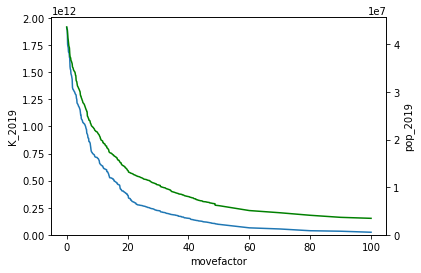

In [13]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
mvmt.sum("seg").K_2019.plot(ax=ax)
mvmt.sum("seg").pop_2019.plot(ax=ax2, c="g")
ax.set_ylim(0, None)
ax2.set_ylim(0, None)

In [14]:
for v in mvmt.variables:
    if mvmt[v].dtype == object:
        mvmt[v] = mvmt[v].astype("unicode")
save(mvmt, PATH_MOVEFACTOR_DATA, mode="w")

In [15]:
client.cluster.close(), client.close()

(None, None)

## Get refA values for GAMS-CIAM for movefactor 1

In [5]:
diaz_segs = open_zarr(PATH_DIAZ_INPUTS_INT, chunks=None).seg.load()
inputs_diaz = load_diaz(diaz_segs)[0]

In [6]:
refA_diaz = get_refA(diaz_segs, PARAMS_DIAZ.movefactor, diaz=True).squeeze(drop=True)

In [7]:
this_refA = refA_diaz.sel(quantile=0.5, drop=True)
mvmt_diaz2000 = calc_exp_moved(
    inputs_diaz.sel(year=2000, drop=True), ["K", "pop"], this_refA
)
mvmt_diaz2100 = calc_exp_moved(
    inputs_diaz.sel(year=2100, drop=True), ["K", "pop"], this_refA
)

In [19]:
mvmt_diaz2000.sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    K        float64 1.262e+12
    pop      float64 3.343e+07

In [9]:
inputs_diaz, lsl = load_diaz(
    this_refA.seg.drop("case"), include_cc=True, include_ncc=False
)
lsl = lsl.sel(scenario="rcp45", quantile=0.5, drop=True)

# calculate ciam costs for no SLR
_, RH_heights = calc_costs(
    inputs_diaz,
    lsl,
    min_R_noadapt=this_refA.drop("case"),
    return_year0_hts=False,
    return_RH_heights=True,
    **get_model_kwargs(True)
)

hts = RH_heights.sel(case=SOLVCASES).isel(case=this_refA.case)
hts["case"] = this_refA.case

mvmt_diaz2100_wcc = calc_exp_moved(
    inputs_diaz.sel(year=2100, drop=True), ["K", "pop"], hts
)

In [10]:
mvmt_diaz2100.sum() / mvmt_diaz2100_wcc.sel(year=2090, drop=True).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    K        float64 0.4082
    pop      float64 0.4354